DATA PREPROCESSING

In [1]:
import os
import pandas as pd
import ipaddress
from PIL import Image
import matplotlib.pyplot as plt
from configurations import binary_lable
from utils import has_digit, remove_digits, remove_suffix, classifi_by_rules, decimal_to_256, nearest_square
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from configurations import app_rules
import math
from imblearn.over_sampling import ADASYN
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
# Thư mục chứa các file dataset đã transfer
dataset_folder = "new_transfered_dataset"
# Thư mục chức các file csv đã gán nhãn
classified_folder = "classified_dataset"
files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]

Preprocessing 1. Đọc Dataset, gán nhãn, merge CSV files

In [3]:
print("##### START READING DATASET ######")
# Danh sách rỗng để lưu trữ các DataFrame
dataframes = []
file_indx = 1
for file in files:
    file_path = os.path.join(dataset_folder, file)
    df = pd.read_csv(file_path)

    # Format tên các cột
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    file_name = file.split(".")[0]

    # Bỏ cột flow_id, timestamp
    df = df.drop('flow_id', axis=1)
    df = df.drop('timestamp', axis=1)

    # Chuyển hóa các địa chỉ IP thành int
    for index, row in df.iterrows():
        int_src_ip = int(ipaddress.ip_address(df.iloc[index]["src_ip"]))
        int_dst_ip = int(ipaddress.ip_address(df.iloc[index]["dst_ip"]))
        df.at[index, 'src_ip'] = int_src_ip
        df.at[index, 'dst_ip'] = int_dst_ip

    # Gán nhãn các row
    processed_name = remove_suffix(file_name)
    label = classifi_by_rules(app_rules, processed_name)
    if(label is not None):
        label_value = label[1]
        df["label"] = label_value
        dataframes.append(df)
    file_indx = file_indx + 1
# Lưu file
merged_df = pd.concat(dataframes, ignore_index=True)
merged_file_path = os.path.join(classified_folder, "app_dataset.csv")
merged_df.to_csv(merged_file_path, index=False)

print("##### READ DATASET DONE ######")

##### START READING DATASET ######
##### READ DATASET DONE ######


Preprocess 2. Mã hóa cơ số 256, áp dụng MinMaxScaler

In [4]:
print("##### START ENCODING DATASET ######")

expanded_df = pd.DataFrame()
merged_traffics = pd.read_csv(f'{classified_folder}/app_dataset.csv')
num_of_rows = merged_traffics.shape[0]
for column_name, column_data in merged_traffics.items():
    count = 1
    for index, value in enumerate(column_data):
        result = decimal_to_256(value)
        max_length = len(result)

        # Tạo tên cột mới và giá trị cho từng kết quả
        for i in range(max_length):
            new_column_name = f'{column_name}_{i + 1}'
            if new_column_name not in expanded_df:
                expanded_df[new_column_name] = 0  # Tạo cột mới nếu cần
            expanded_df.at[index, new_column_name] = result[i]
        count += 1
expanded_df.to_csv(merged_file_path, index=False)

# Scaling dữ liệu
traffics = pd.read_csv(f'{classified_folder}/app_dataset.csv')
selected_columns = [col for col in traffics.columns if col.endswith(
    '_1') and not any(f"{col[:-2]}_{i}" in traffics.columns for i in range(2, 10))]
# Loại bỏ label
selected_columns = [item for item in selected_columns if item != "label_1"]
# Khởi tạo Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 255))
# Áp dụng Min-Max Scaler
traffics[selected_columns] = scaler.fit_transform(
    traffics[selected_columns])
traffics.to_csv(merged_file_path, index=False)

print("##### ENCODING DONE ######")

##### START ENCODING DATASET ######
##### ENCODING DONE ######


Preprocess 3. Áp dụng ADASYN resampling

##### DATASET BALANCING WITH ADASYN. ######


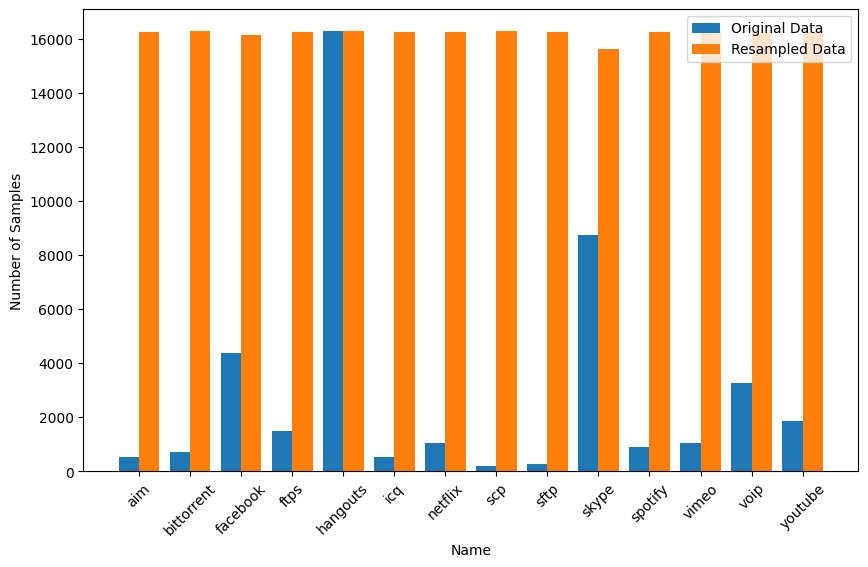

##### RESAMPLING WITH ADASYN DONE ######


In [5]:
print("##### DATASET BALANCING WITH ADASYN. ######")

data = pd.read_csv(f'{classified_folder}/app_dataset.csv')
original_class_distribution = data['label_1'].value_counts()

data.fillna(0, inplace=True)
X = data.drop('label_1', axis=1)  # Tập dữ liệu đầu vào
y = data['label_1']  # Nhãn
adasyn = ADASYN(sampling_strategy='not majority', random_state=42,
                n_neighbors=100)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data = pd.concat(
    [resampled_data, pd.DataFrame(y_resampled, columns=['label_1'])], axis=1)
resampled_class_distribution = resampled_data['label_1'].value_counts()
balanced_file_path = os.path.join(classified_folder, "app_dataset_balanced.csv")

combined_data = pd.concat([original_class_distribution, resampled_class_distribution], axis=1)
combined_data.columns = ['Original Data', 'Resampled Data']
combined_data = combined_data.sort_index()

class_labels = combined_data.index

label_to_name = {rule['label']: rule['name'] for rule in app_rules}
class_labels_mapped = [label_to_name[label] for label in class_labels]

plt.figure(figsize=(10, 6))
width = 0.4

plt.bar(range(len(class_labels_mapped)), combined_data['Original Data'], width=0.4, label='Original Data')
plt.bar([x + width for x in range(len(class_labels_mapped))], combined_data['Resampled Data'], width=0.4, label='Resampled Data')

plt.xlabel('Name')
plt.ylabel('Number of Samples')
plt.xticks([x + width/2 for x in range(len(class_labels_mapped))], class_labels_mapped, rotation=45)  # Set the x-ticks to be class names
plt.legend()
plt.show()
resampled_data.to_csv(balanced_file_path, index=False)
print("##### RESAMPLING WITH ADASYN DONE ######")

Preprocess 4. Fill các dữ liệu còn thiếu bằng 0

In [6]:
print("##### START ADDING ZEROS TO DATASET ######")

df = pd.read_csv(f'{classified_folder}/app_dataset_balanced.csv')
img_shape = nearest_square(df.shape[1]) + 1
num_new_columns = img_shape - df.shape[1]

for i in range(1, num_new_columns + 1):
    new_col_name = f'zeros_{i}'
    df.insert(df.shape[1] - 1, new_col_name, 0)
df.to_csv(merged_file_path, index=False)
print("Dataset's shape", df.shape)

print("##### ADD ZEROS TO DATASET DONE ######")

##### START ADDING ZEROS TO DATASET ######
Dataset's shape (227069, 226)
##### ADD ZEROS TO DATASET DONE ######


Preprocess 5. Chuyển từng dòng dữ liệu thành Image

In [7]:
print("##### START CREATTING IMAGES ######")

df = pd.read_csv(f'{classified_folder}/app_dataset.csv')
img_shape = nearest_square(df.shape[1]) + 1
data_img_shape = int(math.sqrt(img_shape-1))
for index, row in df.iterrows():
    data_row = df.iloc[index]
    label = data_row['label_1']
    data_row = data_row.drop('label_1')

    data_array = data_row.values.reshape(data_img_shape, data_img_shape)
    # Tạo hình ảnh từ mảng numpy
    image = Image.fromarray((data_array).astype('uint8'))

    output_folder = ""
    row_label = row["label_1"]
    for rule in app_rules:
        if rule["label"] == row_label:
            output_folder = rule["name"]

    output_folder_path = os.path.join(
        f'image_dataset/app_dataset/{output_folder}')
    # Tạo đường dẫn đầy đủ đến thư mục đích -> lưu
    output_path = os.path.join(
        f'image_dataset/app_dataset/{output_folder}', f'{index + 2}.png')

    # Kiểm tra nếu thư mục đích chưa tồn tại, thì tạo thư mục
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    image.save(output_path)

print("##### CONVERT TO IMAGE DONE. ######")

##### START CREATTING IMAGES ######
##### CONVERT TO IMAGE DONE. ######


MODEL TRAINING

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import torch.utils.data as data
import random
import numpy as np

In [3]:
class CNNAppClassifier(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNAppClassifier, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 3 * 3, 128)
        self.relu5 = nn.ReLU()

        self.dropout = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu5(x)

        x = self.dropout(x)

        x = self.fc2(x)
        return x

model = CNNAppClassifier()

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((15, 15)),  # Chuyển đổi kích thước thành 9x9
    transforms.Grayscale(),    # Chuyển đổi thành ảnh xám
    transforms.ToTensor(),     # Chuyển đổi thành tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa dữ liệu
])

In [5]:
# Đọc dataset theo thư mục (theo document của pytorch)
dataset_root = "image_dataset/app_dataset"  # Thư mục gốc chứa dataset
train_dataset = datasets.ImageFolder(
    root=dataset_root, transform=data_transform)

In [6]:
# Lấy danh sách các lớp (labels)
class_names = train_dataset.classes
class_names_title = train_dataset.classes

# Lấy từ điển class_to_idx từ train_dataset
class_to_idx = train_dataset.class_to_idx

# In ra các label và tên thư mục tương ứng
for label in class_names:
    idx = class_to_idx[label]
    print(f"Label: {idx}, Label's name: {label}")

Label: 0, Label's name: aim
Label: 1, Label's name: bittorrent
Label: 2, Label's name: facebook
Label: 3, Label's name: ftps
Label: 4, Label's name: hangouts
Label: 5, Label's name: icq
Label: 6, Label's name: netflix
Label: 7, Label's name: scp
Label: 8, Label's name: sftp
Label: 9, Label's name: skype
Label: 10, Label's name: spotify
Label: 11, Label's name: vimeo
Label: 12, Label's name: voip
Label: 13, Label's name: youtube


In [7]:
# Chia Train/Validate/Test tỉ lệ 70 - 15 - 15
batch_size = 256  # Kích thước batch
total_samples = len(train_dataset)

# Set the desired fraction of the dataset you want to use (1/3 in this case)
fraction_to_use = 1
samples_to_use = int(fraction_to_use * total_samples)

# Randomly select one-third of the dataset
selected_samples = random.sample(range(total_samples), samples_to_use)

# Create a Subset of the dataset using the selected samples
train_dataset = data.Subset(train_dataset, selected_samples)
total_samples = len(train_dataset)

train_size = int((0.7 * total_samples))
validate_size = int((0.15 * total_samples))
test_size = total_samples - train_size - validate_size

print("Total", total_samples)
print("Test Amount", test_size)
print("Train Amount", train_size)
print("Validation Amount", validate_size)

train_dataset, validate_dataset, test_dataset = random_split(
    train_dataset, [train_size, validate_size, test_size])

train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validate_loader = DataLoader(
        validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

Total 227069
Test Amount 34061
Train Amount 158948
Validation Amount 34060


In [8]:
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    current_gpu = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_gpu)
    print(f"Have {gpu_count} GPU available.")
    print(f"GPU's name: {gpu_name}")
else:
    print("No GPU available.")
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Have 1 GPU available.
GPU's name: NVIDIA GeForce GTX 1050
11.7


In [9]:
num_epochs = 200  # Số lượng epoch
learning_rate = 0.0001

In [10]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
best_accuracy = 0.0  # Giá trị accuracy tốt nhất
patience = 20  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện
weight_decay = 0.0001

In [124]:
if torch.cuda.is_available():
    # Chuyển mô hình và dữ liệu lên GPU
    model = model.to(device)

    # Tạo hàm mất mát và tối ưu hóa trên GPU
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_list = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
        train_loss = 0
        correct_predictions = 0
        total_samples = 0
        model.train()
        # Lặp qua từng batch trong dữ liệu
        for images, labels in train_loader:  # train_dataloader chứa dữ liệu huấn luyện
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # Feed-forward
            loss = criterion(outputs, labels)  # Tính hàm mất mát

            optimizer.zero_grad()  # Xóa gradient
            loss.backward()  # Lan truyền ngược để tính gradient
            optimizer.step()  # Cập nhật trọng số mô hình
            train_loss += loss.item()  # Cost
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        train_accuracy = correct_predictions / total_samples
        train_accuracy_list.append(train_accuracy)
        # Lost: Trung bình cộng các Cost
        train_loss_list.append(train_loss/len(train_loader))

        # Đánh giá trên tập validate
        validate_loss = 0
        validate_correct_predictions = 0
        validate_total_samples = 0

        model.eval()  # Chuyển sang chế độ đánh giá

        for i, (images, labels) in enumerate(validate_loader):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():  # Không tính đạo hàm trong quá trình đánh giá
                outputs = model(images)
                loss = criterion(outputs, labels)  # Tính hàm mất mát
                validate_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                validate_total_samples += labels.size(0)
                validate_correct_predictions += (predicted ==
                                                 labels).sum().item()

        validate_accuracy = validate_correct_predictions / validate_total_samples
        validate_accuracy_list.append(validate_accuracy)
        validate_loss_list.append(validate_loss/len(validate_loader))

        print(
            f"Training loss={train_loss_list[-1]}, Training Accuracy={train_accuracy * 100:.2f}%, "
            f"Validation loss={validate_loss_list[-1]}, Validation Accuracy={validate_accuracy * 100:.2f}%")

        if validate_loss_list[-1] >= best_loss:
            no_improvement_count += 1
        else:
            best_loss = validate_loss_list[-1]
            no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch 1/200: Training loss=1.7322244897556767, Training Accuracy=42.36%, Validation loss=1.372348184905835, Validation Accuracy=55.92%
Epoch 2/200: Training loss=1.3479407277084203, Training Accuracy=54.43%, Validation loss=1.1278547800298948, Validation Accuracy=62.29%
Epoch 3/200: Training loss=1.1620709377786387, Training Accuracy=60.11%, Validation loss=0.9993115810316, Validation Accuracy=66.71%
Epoch 4/200: Training loss=1.052716787310614, Training Accuracy=63.54%, Validation loss=0.9153006486038664, Validation Accuracy=68.95%
Epoch 5/200: Training loss=0.9773197790274873, Training Accuracy=65.97%, Validation loss=0.8551898692081223, Validation Accuracy=70.38%
Epoch 6/200: Training loss=0.9159115024042974, Training Accuracy=67.92%, Validation loss=0.8018759075385421, Validation Accuracy=71.70%
Epoch 7/200: Training loss=0.8705994789151178, Training Accuracy=69.39%, Validation loss=0.7660350906315134, Validation Accuracy=73.14%
Epoch 8/200: Training loss=0.8306993241279406, Traini

In [125]:
model_save_path = "GUI/models/app_classification_2.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/app_classification_2.pth


In [15]:
model_save_path = "GUI/models/app_classification.pth"
# Load lại model
model = CNNAppClassifier()
model = model.to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)

checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

Dự đoán trên tập test

In [32]:
model.eval()  # Chuyển mô hình sang chế độ đánh giá
correct_predictions = 0
total_samples = 0
all_predictions = []
all_labels = []

# Khởi tạo danh sách để lưu trữ xác suất dự đoán cho từng lớp
all_probs = []

with torch.no_grad():  # Tắt tính toán gradient trong quá trình đánh giá
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # Feed-forward
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

test_accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
all_probs = np.array(all_probs)

label_to_class_name = {index: class_name for index,
                       class_name in enumerate(class_names_title)}
label_display = [label_to_class_name[label]
                 for label in range(len(class_names_title))]

for label, class_name in enumerate(label_display):
    print(f"Label {label}: {class_name}")

Test Accuracy: 88.44%
Label 0: aim
Label 1: bittorrent
Label 2: facebook
Label 3: ftps
Label 4: hangouts
Label 5: icq
Label 6: netflix
Label 7: scp
Label 8: sftp
Label 9: skype
Label 10: spotify
Label 11: vimeo
Label 12: voip
Label 13: youtube


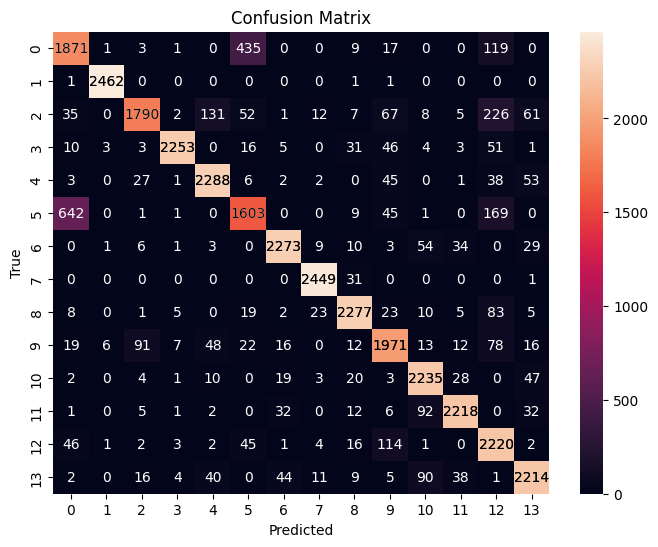

In [33]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

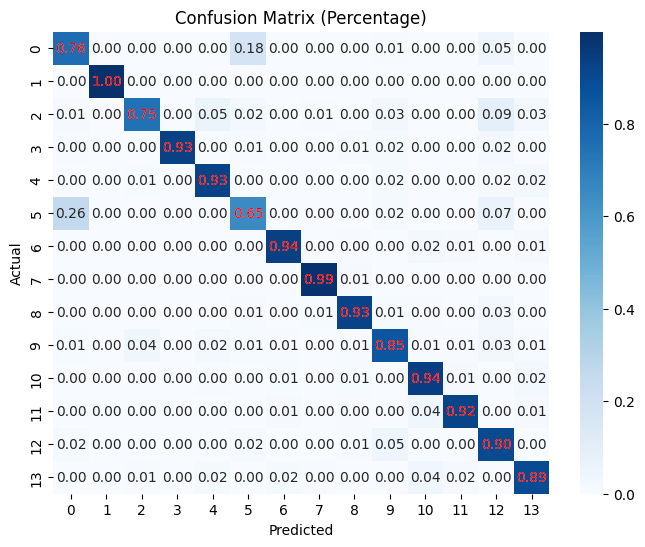

In [34]:
# Tính confusion matrix theo tỉ số
cm = confusion_matrix(all_labels, all_predictions)

# Chuyển ma trận nhầm lẫn sang dạng phần trăm
# Chia mỗi hàng cho tổng của hàng đó
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# In ra confusion matrix dưới dạng phần trăm
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5,
             f"{cm[i, i] / sum(cm[i, :]):.2f}", ha="center", va="center", color="red")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

Phân tích trên đồ thị

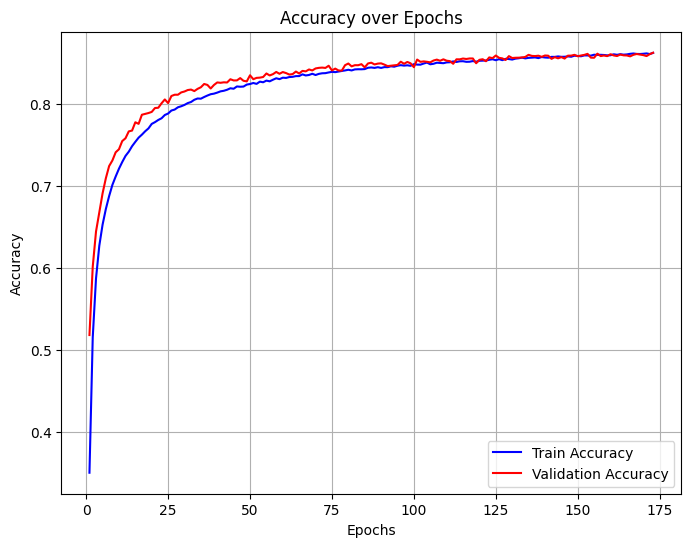

In [35]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

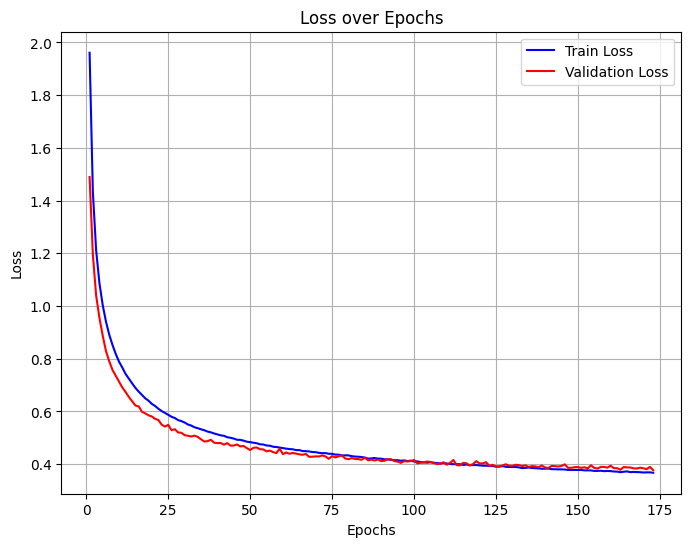

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Đánh giá model theo từng đại lượng

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import pandas as pd

In [38]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

accuracies = []
for label in range(len(class_names_title)):
    indices = [i for i, l in enumerate(all_labels) if l == label]
    label_predictions = [all_predictions[i] for i in indices]
    label_true = [all_labels[i] for i in indices]
    accuracy = accuracy_score(label_true, label_predictions)
    accuracies.append(accuracy)

data = {'Class': label_display, 'Precision': precisions,
        'Recall': recalls, 'F1-Score': f1_scores, 'Accuracy': accuracies}
df = pd.DataFrame(data)

average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(df)
print("Model's precision", average_precision)
print("Model's recall", average_recall)
print("Model's f1-score",average_f1_score)
print(f"Model's Accuracy: {test_accuracy}%")

         Class  Precision    Recall  F1-Score  Accuracy
0          aim   0.708712  0.761808  0.734301  0.761808
1   bittorrent   0.995150  0.998783  0.996963  0.998783
2     facebook   0.918420  0.746767  0.823746  0.746767
3         ftps   0.988158  0.928689  0.957501  0.928689
4     hangouts   0.906498  0.927818  0.917034  0.927818
5          icq   0.729299  0.648725  0.686657  0.648725
6      netflix   0.949061  0.938093  0.943545  0.938093
7          scp   0.974532  0.987102  0.980777  0.987102
8         sftp   0.931669  0.925234  0.928440  0.925234
9        skype   0.840153  0.852878  0.846468  0.852878
10     spotify   0.891148  0.942243  0.915984  0.942243
11       vimeo   0.946246  0.923782  0.934879  0.923782
12        voip   0.743719  0.903541  0.815877  0.903541
13     youtube   0.899634  0.894907  0.897264  0.894907
Model's precision 0.8873142162859947
Model's recall 0.8843120910818774
Model's f1-score 0.8842453955892571
Model's Accuracy: 0.8844132585655148%


AUC for aim: 0.99
AUC for bittorrent: 1.00
AUC for facebook: 0.99
AUC for ftps: 1.00
AUC for hangouts: 1.00
AUC for icq: 0.98
AUC for netflix: 1.00
AUC for scp: 1.00
AUC for sftp: 1.00
AUC for skype: 0.99
AUC for spotify: 1.00
AUC for vimeo: 1.00
AUC for voip: 0.99
AUC for youtube: 1.00


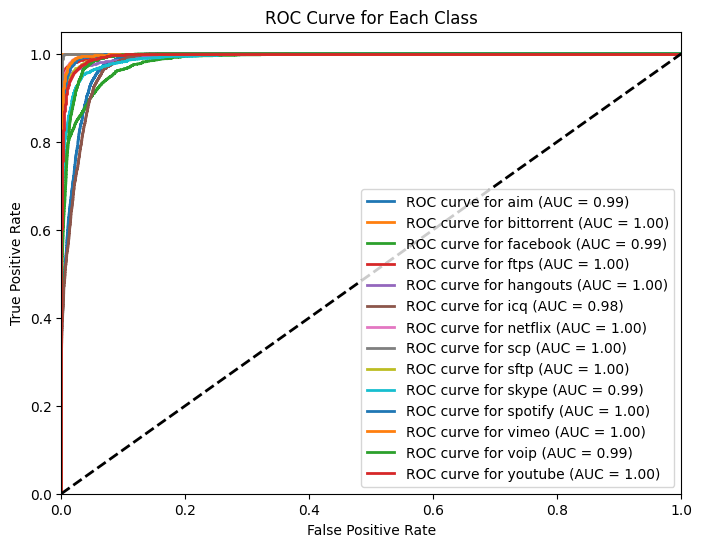

In [39]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names_title)):
    fpr[i], tpr[i], _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f'AUC for {class_names_title[i]}: {roc_auc[i]:.2f}')

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names_title):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve for {class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

Transfer learning

In [2]:
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torch.utils.data import random_split
import random
import torch.utils.data as data
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.Grayscale(num_output_channels=3), # Chuyển đổi thành ảnh xám, 3 kênh màu xám
    transforms.ToTensor(),     # Chuyển đổi thành tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa dữ liệu
])

In [4]:
dataset_root = "image_dataset/app_dataset/"  # Thư mục gốc chứa dataset
train_dataset = ImageFolder(
    root=dataset_root, transform=data_transform)
print(train_dataset.classes)

['aim', 'bittorrent', 'facebook', 'ftps', 'hangouts', 'icq', 'netflix', 'scp', 'sftp', 'skype', 'spotify', 'vimeo', 'voip', 'youtube']


In [5]:
batch_size = 512  # Kích thước batch
total_samples = len(train_dataset)

# Chia lượng data được sử dụng
fraction_to_use = 1
samples_to_use = int(fraction_to_use * total_samples)

# Lấy datata random theo tỉ lệ
selected_samples = random.sample(range(total_samples), samples_to_use)

# Tạo ra các subset trên mỗi sample
train_dataset = data.Subset(train_dataset, selected_samples)
total_samples = len(train_dataset)

train_size = int(0.7 * total_samples)
validate_size = int(0.15 * total_samples)
test_size = total_samples - train_size - validate_size

print("Total", total_samples)
print("Test Amount", test_size)
print("Train Amount", train_size)
print("Validation Amount", validate_size)

train_dataset, validate_dataset, test_dataset = random_split(
    train_dataset, [train_size, validate_size, test_size])

# Tạo DataLoader sử dụng pin_memory để tăng hiệu suất nếu cần thiết
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validate_loader = DataLoader(
    validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

Total 227069
Test Amount 34061
Train Amount 158948
Validation Amount 34060


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


RestNet50

In [65]:
resnet50 = models.resnet50(pretrained=True)
# Fine tuning
for param in resnet50.parameters():
    param.requires_grad = False
num_classes = 14
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), 
    nn.LogSoftmax(dim=1)
)

In [66]:
learning_rate = 0.0001
num_epochs = 100
weight_decay = 0.001

In [67]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        resnet50.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [68]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 5  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [69]:
resnet50.to(device)
for epoch in range(num_epochs):
    resnet50.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    resnet50.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/100, Train Loss: 2.1348, Train Accuracy: 30.89%, Validation Loss: 1.8306, Validation Accuracy: 41.54%
Epoch 2/100, Train Loss: 1.8391, Train Accuracy: 40.18%, Validation Loss: 1.6987, Validation Accuracy: 44.94%
Epoch 3/100, Train Loss: 1.7402, Train Accuracy: 43.18%, Validation Loss: 1.6250, Validation Accuracy: 46.81%
Epoch 4/100, Train Loss: 1.6790, Train Accuracy: 45.04%, Validation Loss: 1.5761, Validation Accuracy: 48.08%
Epoch 5/100, Train Loss: 1.6332, Train Accuracy: 46.30%, Validation Loss: 1.5402, Validation Accuracy: 48.75%
Epoch 6/100, Train Loss: 1.5958, Train Accuracy: 47.57%, Validation Loss: 1.5076, Validation Accuracy: 50.16%
Epoch 7/100, Train Loss: 1.5660, Train Accuracy: 48.35%, Validation Loss: 1.4777, Validation Accuracy: 51.08%
Epoch 8/100, Train Loss: 1.5392, Train Accuracy: 49.03%, Validation Loss: 1.4566, Validation Accuracy: 51.53%
Epoch 9/100, Train Loss: 1.5148, Train Accuracy: 49.81%, Validation Loss: 1.4281, Validation Accuracy: 52.46%
Epoch 10/1

In [70]:
model_save_path = "GUI/models/app_classification_resnet50.pth"
torch.save({
    'model_state_dict': resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/app_classification_resnet50.pth


In [8]:
model_save_path = "GUI/models/app_classification_resnet50.pth"
resnet50 = models.resnet50(pretrained=True)
# Fine tuning
for param in resnet50.parameters():
    param.requires_grad = False
num_classes = 14
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), 
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
resnet50.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [9]:
resnet50 = resnet50.to(device)
resnet50.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = resnet50(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.6940195531546344


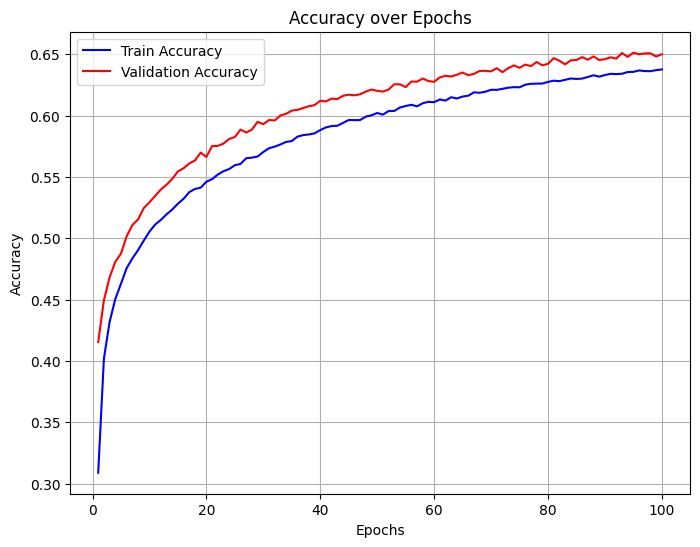

In [10]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

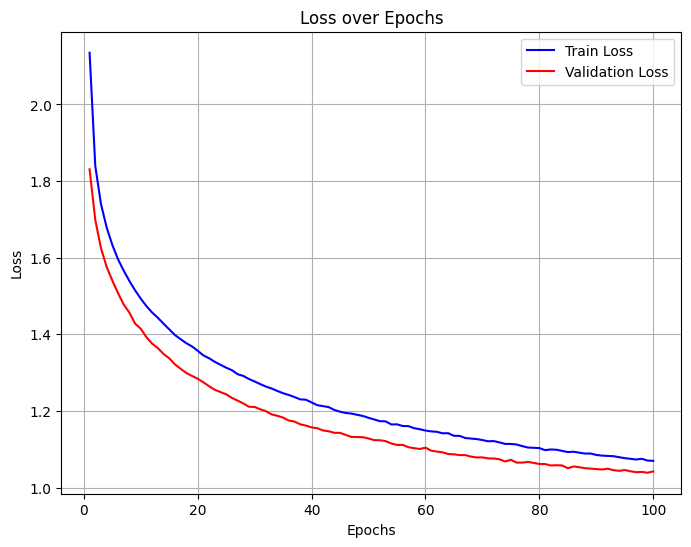

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

ResNet50's Confusion Matrix:


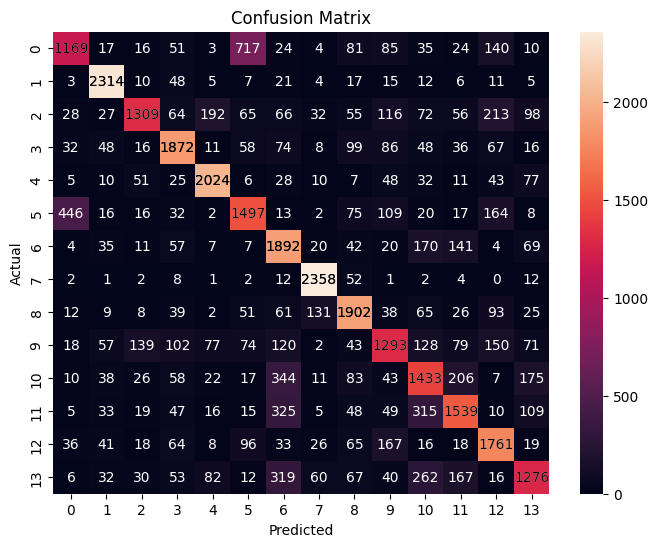

In [12]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("ResNet50's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

resnet50_precision = np.mean(precisions)
resnet50_recall = np.mean(recalls)
resent50_f1_score = np.mean(f1_scores)
resnet50_acc = predict_accuracy

print("ResNet50's precision", resnet50_precision)
print("ResNet50's recall", resnet50_recall)
print("ResNet50's f1-score",resent50_f1_score)
print(f"ResNet50's Accuracy: {resnet50_acc}")

ResNet50's precision 0.6959574429949802
ResNet50's recall 0.6930936338832859
ResNet50's f1-score 0.6899100887632159
ResNet50's Accuracy: 0.6940195531546344


AlexNet

In [32]:
alexnet = models.alexnet(pretrained=True)
# Fine tuning
for param in alexnet.features.parameters():
    param.requires_grad = False

in_features = alexnet.classifier[6].in_features
num_classes = 14
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

In [33]:
learning_rate = 0.0001
num_epochs = 100
weight_decay = 0.001

In [34]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        alexnet.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [35]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 5  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [36]:
alexnet.to(device)
for epoch in range(num_epochs):
    alexnet.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    alexnet.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')


    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/100, Train Loss: 1.9215, Train Accuracy: 35.50%, Validation Loss: 1.5075, Validation Accuracy: 49.02%
Epoch 2/100, Train Loss: 1.6203, Train Accuracy: 45.22%, Validation Loss: 1.3597, Validation Accuracy: 53.00%
Epoch 3/100, Train Loss: 1.5087, Train Accuracy: 48.61%, Validation Loss: 1.2696, Validation Accuracy: 56.12%
Epoch 4/100, Train Loss: 1.4326, Train Accuracy: 51.09%, Validation Loss: 1.2191, Validation Accuracy: 58.07%
Epoch 5/100, Train Loss: 1.3765, Train Accuracy: 52.96%, Validation Loss: 1.1773, Validation Accuracy: 59.15%
Epoch 6/100, Train Loss: 1.3347, Train Accuracy: 54.37%, Validation Loss: 1.1329, Validation Accuracy: 60.73%
Epoch 7/100, Train Loss: 1.2946, Train Accuracy: 55.50%, Validation Loss: 1.0929, Validation Accuracy: 61.69%
Epoch 8/100, Train Loss: 1.2606, Train Accuracy: 56.54%, Validation Loss: 1.0743, Validation Accuracy: 62.40%
Epoch 9/100, Train Loss: 1.2317, Train Accuracy: 57.53%, Validation Loss: 1.0435, Validation Accuracy: 63.40%
Epoch 10/1

In [37]:
model_save_path = "GUI/models/app_classification_alexnet.pth"
torch.save({
    'model_state_dict': alexnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/app_classification_alexnet.pth


In [9]:
model_save_path = "GUI/models/app_classification_alexnet.pth"
alexnet = models.alexnet(pretrained=True)
# Fine tuning
for param in alexnet.features.parameters():
    param.requires_grad = False

in_features = alexnet.classifier[6].in_features
num_classes = 14
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
alexnet.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [10]:
alexnet = alexnet.to(device)
alexnet.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = alexnet(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.7971286808960395


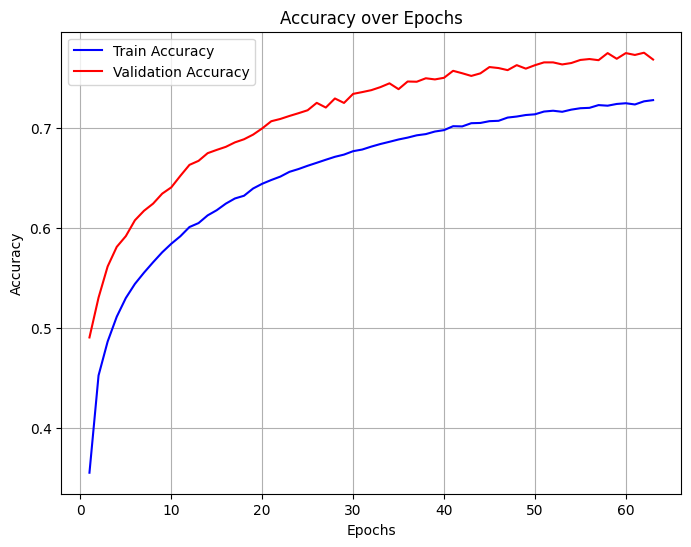

In [11]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

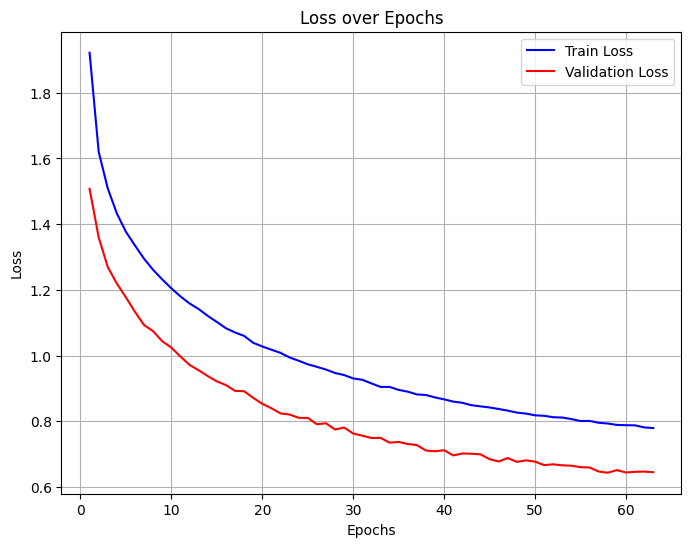

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

AlexNet's Confusion Matrix:


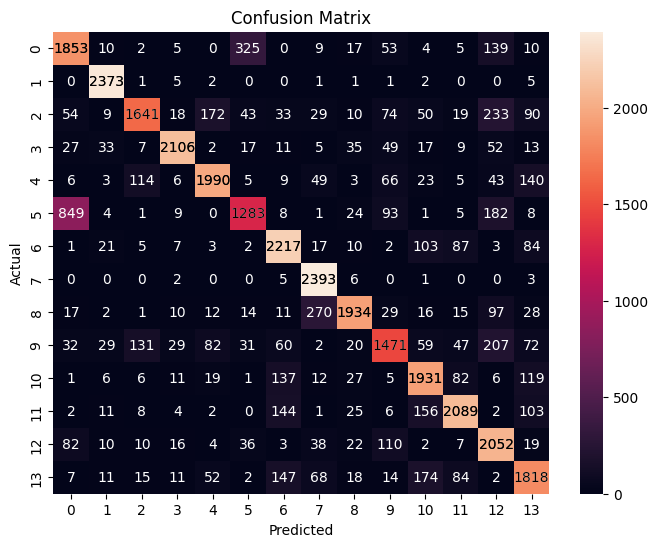

In [13]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("AlexNet's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

alexnet_precision = np.mean(precisions)
alexnet_recall = np.mean(recalls)
alexnet_f1_score = np.mean(f1_scores)
alexnet_acc = predict_accuracy

print("AlexNet's precision", alexnet_precision)
print("AlexNet's recall", alexnet_recall)
print("AlexNet's f1-score",alexnet_f1_score)
print(f"AlexNet's Accuracy: {alexnet_acc}")

AlexNet's precision 0.8014933834564468
AlexNet's recall 0.7970972721548358
AlexNet's f1-score 0.794722365354339
AlexNet's Accuracy: 0.7971286808960395


VGG-16

In [25]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 14
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

In [26]:
learning_rate = 0.0001
num_epochs = 20 # Mô hình VGG quá lớn để train nhiều epochs
weight_decay = 0.001

In [27]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        vgg16.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [28]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 5  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [11]:
vgg16.to(device)
for epoch in range(num_epochs):
    vgg16.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    vgg16.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/20, Train Loss: 1.8078, Train Accuracy: 39.40%, Validation Loss: 1.4044, Validation Accuracy: 51.79%
Epoch 2/20, Train Loss: 1.4042, Train Accuracy: 52.42%, Validation Loss: 1.1763, Validation Accuracy: 58.41%
Epoch 3/20, Train Loss: 1.2415, Train Accuracy: 57.49%, Validation Loss: 1.0736, Validation Accuracy: 62.85%
Epoch 4/20, Train Loss: 1.1519, Train Accuracy: 60.54%, Validation Loss: 0.9721, Validation Accuracy: 66.02%
Epoch 5/20, Train Loss: 1.0852, Train Accuracy: 62.85%, Validation Loss: 0.9379, Validation Accuracy: 67.16%
Epoch 6/20, Train Loss: 1.0409, Train Accuracy: 64.30%, Validation Loss: 0.8891, Validation Accuracy: 68.82%
Epoch 7/20, Train Loss: 1.0050, Train Accuracy: 65.55%, Validation Loss: 0.8516, Validation Accuracy: 69.69%
Epoch 8/20, Train Loss: 0.9769, Train Accuracy: 66.45%, Validation Loss: 0.8467, Validation Accuracy: 70.23%
Epoch 9/20, Train Loss: 0.9503, Train Accuracy: 67.49%, Validation Loss: 0.8289, Validation Accuracy: 70.38%
Epoch 10/20, Train 

In [12]:
model_save_path = "GUI/models/app_classification_vgg16.pth"
torch.save({
    'model_state_dict': vgg16.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/app_classification_vgg16.pth


In [29]:
model_save_path = "GUI/models/app_classification_vgg16.pth"
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 14
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
vgg16.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

Train tiếp cho VGG-16

In [30]:
more_epoch = 50
last_epoch = len(train_loss_list)
end_epoch = last_epoch + more_epoch
patience = 5

print("Last epoch: ", last_epoch)
print("End epoch: ", end_epoch)

Last epoch:  20
End epoch:  70


In [31]:
vgg16.to(device)
criterion = nn.CrossEntropyLoss().to(device)
for epoch in range(last_epoch, end_epoch):
    vgg16.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    vgg16.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{end_epoch}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 21/70, Train Loss: 0.8278, Train Accuracy: 71.38%, Validation Loss: 0.6630, Validation Accuracy: 76.82%
Epoch 22/70, Train Loss: 0.8255, Train Accuracy: 71.51%, Validation Loss: 0.6634, Validation Accuracy: 76.82%
Epoch 23/70, Train Loss: 0.8282, Train Accuracy: 71.38%, Validation Loss: 0.6634, Validation Accuracy: 76.82%
Epoch 24/70, Train Loss: 0.8274, Train Accuracy: 71.47%, Validation Loss: 0.6632, Validation Accuracy: 76.82%
Epoch 25/70, Train Loss: 0.8268, Train Accuracy: 71.45%, Validation Loss: 0.6637, Validation Accuracy: 76.82%
Epoch 26/70, Train Loss: 0.8252, Train Accuracy: 71.55%, Validation Loss: 0.6631, Validation Accuracy: 76.82%
Early stopping at epoch 26


In [32]:
model_save_path = "GUI/models/app_classification_vgg16.pth"
torch.save({
    'model_state_dict': vgg16.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/app_classification_vgg16.pth


In [ ]:
model_save_path = "GUI/models/app_classification_vgg16.pth"
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

in_features = vgg16.classifier[-1].in_features
num_classes = 14
vgg16.classifier[-1] = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
vgg16.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [33]:
vgg16 = vgg16.to(device)
vgg16.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = vgg16(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.7681218989460087


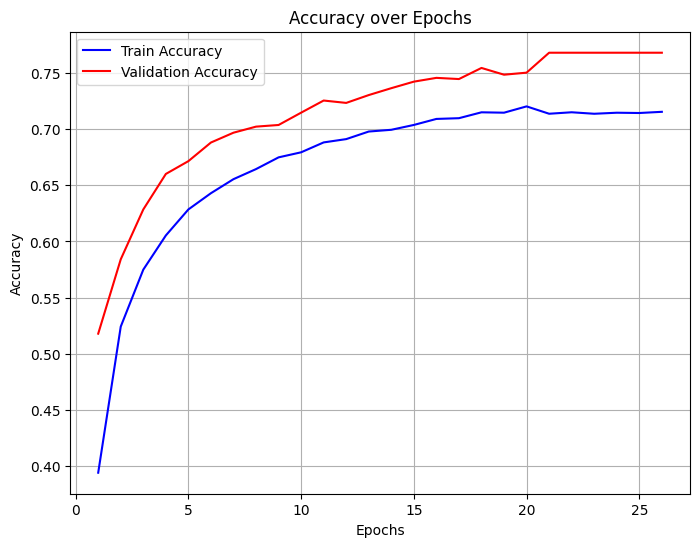

In [34]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

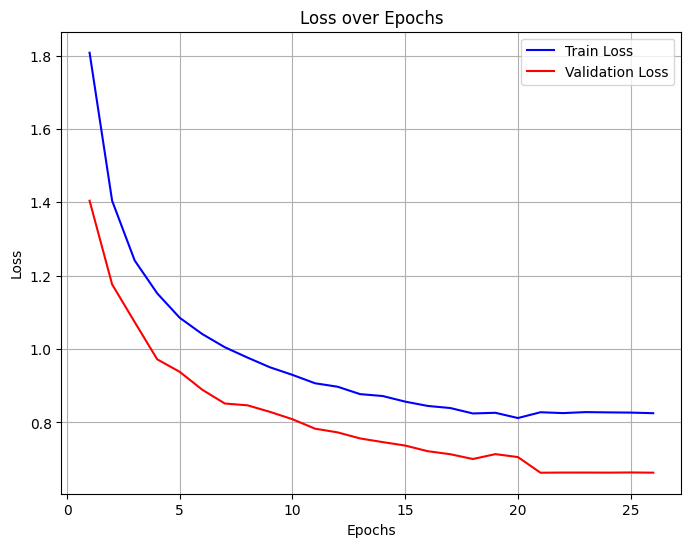

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

VGG-16's Confusion Matrix:


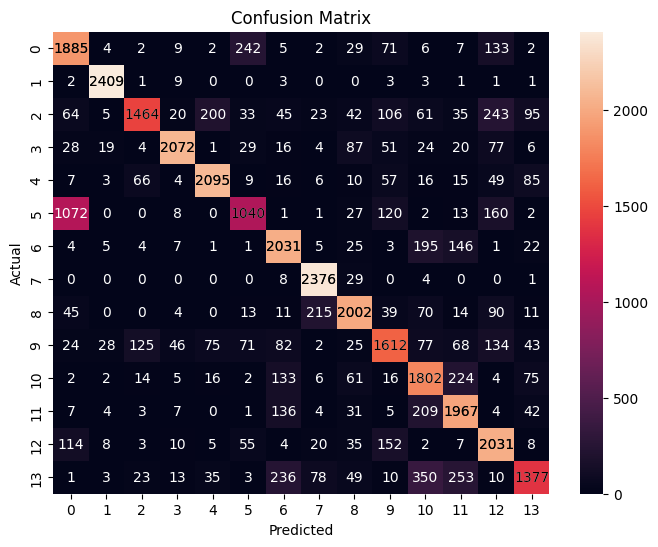

In [36]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("VGG-16's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

vgg16_precision = np.mean(precisions)
vgg16_recall = np.mean(recalls)
vgg16_f1_score = np.mean(f1_scores)
vgg16_acc = predict_accuracy

print("VGG-16's precision", vgg16_precision)
print("VGG-16's recall", vgg16_recall)
print("VGG-16's f1-score",vgg16_f1_score)
print(f"VGG-16's Accuracy: {vgg16_acc}")

VGG-16's precision 0.7756576690918117
VGG-16's recall 0.7682125915959782
VGG-16's f1-score 0.7639697139712853
VGG-16's Accuracy: 0.7681218989460087


DenseNet121

In [18]:
densenet121 = models.densenet121(pretrained=True)

for param in densenet121.features.parameters():
    param.requires_grad = False

in_features = densenet121.classifier.in_features
num_classes = 14
densenet121.classifier = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

In [19]:
learning_rate = 0.0001
num_epochs = 100
weight_decay = 0.001

In [20]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
        densenet121.classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [21]:
# Các giá trị cần lưu để đánh giá model
train_loss_list = []
train_accuracy_list = []
validate_loss_list = []  # Để lưu loss trên tập validate
validate_accuracy_list = []  # Để lưu accuracy trên tập validate

best_loss = float('inf')  # Giá trị loss tốt nhất
patience = 5  # Số epoch không giảm loss hoặc không tăng accuracy cho phép trước khi dừng
no_improvement_count = 0  # Đếm số epoch không cải thiện

In [22]:
densenet121.to(device)
for epoch in range(num_epochs):
    densenet121.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = densenet121(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(average_train_loss)

    # Validation
    densenet121.eval()
    total_validation_loss = 0.0
    correct_validation = 0
    total_validation = 0
    
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = densenet121(inputs)
            loss = criterion(outputs, labels)
            
            total_validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
    
    validation_accuracy = correct_validation / total_validation
    average_validation_loss = total_validation_loss / len(validate_loader)
    validate_accuracy_list.append(validation_accuracy)
    validate_loss_list.append(average_validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * validation_accuracy:.2f}%')

    if validate_loss_list[-1] >= best_loss:
        no_improvement_count += 1
    else:
        best_loss = validate_loss_list[-1]
        no_improvement_count = 0
        # Nếu không cải thiện trong số lần đã định, dừng huấn luyện
    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/100, Train Loss: 2.2310, Train Accuracy: 26.99%, Validation Loss: 1.8993, Validation Accuracy: 39.76%
Epoch 2/100, Train Loss: 1.8924, Train Accuracy: 38.15%, Validation Loss: 1.7242, Validation Accuracy: 44.44%
Epoch 3/100, Train Loss: 1.7673, Train Accuracy: 42.00%, Validation Loss: 1.6389, Validation Accuracy: 46.99%
Epoch 4/100, Train Loss: 1.6960, Train Accuracy: 44.06%, Validation Loss: 1.5818, Validation Accuracy: 48.48%
Epoch 5/100, Train Loss: 1.6463, Train Accuracy: 45.64%, Validation Loss: 1.5390, Validation Accuracy: 49.43%
Epoch 6/100, Train Loss: 1.6060, Train Accuracy: 46.85%, Validation Loss: 1.5043, Validation Accuracy: 50.58%
Epoch 7/100, Train Loss: 1.5728, Train Accuracy: 47.76%, Validation Loss: 1.4775, Validation Accuracy: 51.29%
Epoch 8/100, Train Loss: 1.5497, Train Accuracy: 48.39%, Validation Loss: 1.4554, Validation Accuracy: 51.91%
Epoch 9/100, Train Loss: 1.5275, Train Accuracy: 49.20%, Validation Loss: 1.4361, Validation Accuracy: 52.48%
Epoch 10/1

In [23]:
model_save_path = "GUI/models/app_classification_densenet121.pth"
torch.save({
    'model_state_dict': densenet121.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss_list': train_loss_list,
    'validate_loss_list': validate_loss_list,
    'train_accuracy_list': train_accuracy_list,
    'validate_accuracy_list': validate_accuracy_list
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to GUI/models/app_classification_densenet121.pth


In [23]:
model_save_path = "GUI/models/app_classification_densenet121.pth"

densenet121 = models.densenet121(pretrained=True)

for param in densenet121.features.parameters():
    param.requires_grad = False

in_features = densenet121.classifier.in_features
num_classes = 14
densenet121.classifier = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

checkpoint = torch.load(model_save_path)
densenet121.load_state_dict(checkpoint['model_state_dict'])

train_loss_list = checkpoint['train_loss_list']
validate_loss_list = checkpoint['validate_loss_list']
train_accuracy_list = checkpoint['train_accuracy_list']
validate_accuracy_list = checkpoint['validate_accuracy_list']

In [24]:
densenet121 = densenet121.to(device)
densenet121.eval()
correct_predictions = 0
total_predictions = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = densenet121(inputs)
            
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    predict_accuracy = correct_predictions / total_predictions
    
    print(predict_accuracy)

0.6548545257038842


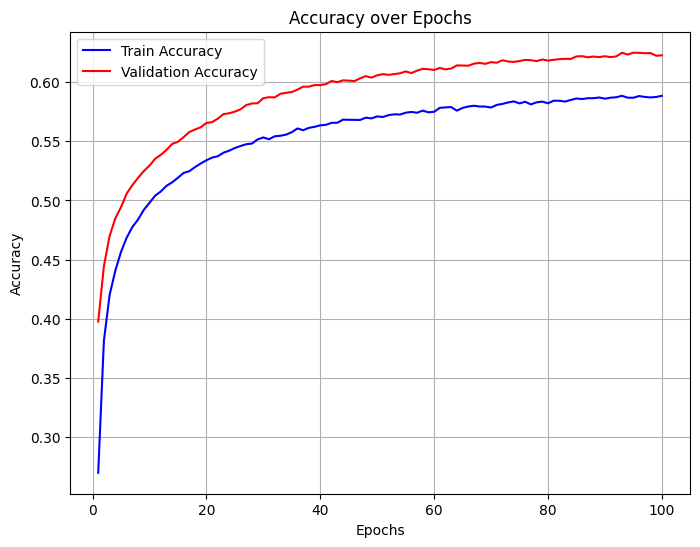

In [25]:
epochs = range(1, len(train_accuracy_list) + 1)
# Độ chính xác trên tập huấn luyện và tập validate
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy_list, 'b', label='Train Accuracy')
plt.plot(epochs, validate_accuracy_list, 'r', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

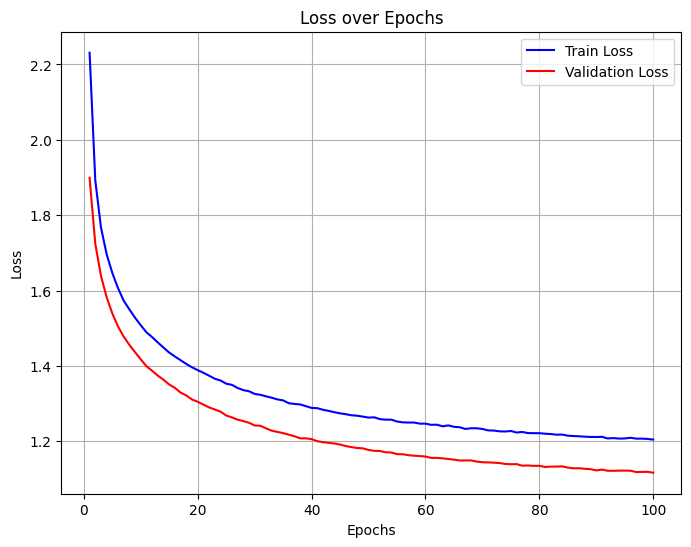

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, 'b', label='Train Loss')
plt.plot(epochs, validate_loss_list, 'r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

DenseNet121's Confusion Matrix:


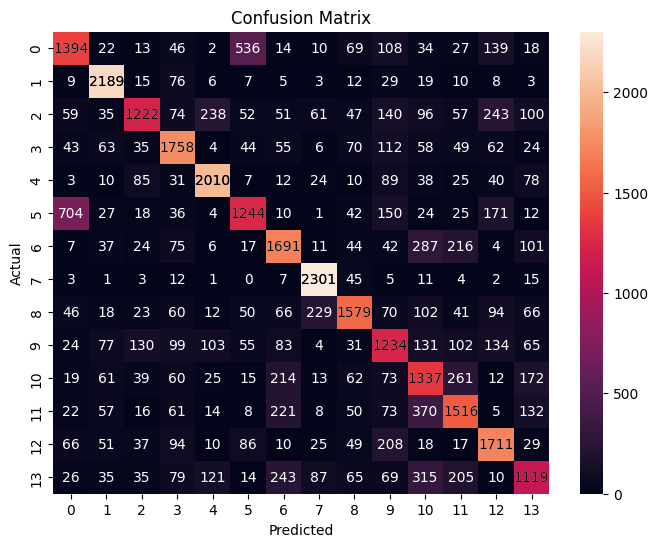

In [27]:
# Tính confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# In ra confusion matrix
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g",
            xticklabels=class_names, yticklabels=class_names)

for i in range(len(class_names)):
    plt.text(i + 0.5, i + 0.5, cm[i, i], ha="center",
             va="center", color="black")

print("DenseNet121's Confusion Matrix:")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Tính Precision, Recall, và F1-Score cho từng lớp
precisions = precision_score(all_labels, all_predictions, average=None)
recalls = recall_score(all_labels, all_predictions, average=None)
f1_scores = f1_score(all_labels, all_predictions, average=None)

densenet121_precision = np.mean(precisions)
densenet121_recall = np.mean(recalls)
densenet121_f1_score = np.mean(f1_scores)
densenet121_acc = predict_accuracy

print("DenseNet121's precision", densenet121_precision)
print("DenseNet121's recall", densenet121_recall)
print("DenseNet121's f1-score",densenet121_f1_score)
print(f"DenseNet121's Accuracy: {densenet121_acc}")

DenseNet121's precision 0.6540174077170567
DenseNet121's recall 0.655184946750998
DenseNet121's f1-score 0.6511528790568423
DenseNet121's Accuracy: 0.6548545257038842
